## PASO 1: GENERAR DATOS SINTÉTICOS CON RELACIÓN DISPERSA Y CORRELACIÓN

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

np.random.seed(42) # Para reproducibilidad
# Parámetros
n_samples = 150
n_features = 15
n_informative = 5 # Número de características que realmente afectan la variable objetivo
# las primeras  variables tendrán coeficientes no nulos

true_coeffs = np.zeros(n_features) # Coeficientes verdaderos
true_coeffs[:n_informative] = np.random.uniform(5,15, size = n_informative) # Asignar valores aleatorios a los coeficientes informativos

# generar datos de entrada con correlación

cov_matrix = np.full((n_features, n_features), 0.5) # Matriz de covarianza
np.fill_diagonal(cov_matrix, 1) # Varianza en la diagonal
X = np.random.multivariate_normal(mean=np.zeros(n_features), cov=cov_matrix, size=n_samples) # Datos de entrada

# Generar variable objetivo con ruido
noise = np.random.normal(0,5,n_samples) # Ruido gaussiano
y = X @ true_coeffs + noise # Variable objetivo 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Datos generados: {n_samples} muestras, {n_features} características.")
print(f"Primeros 5 coeficientes verdaderos (informativos): {true_coeffs[:5]}")
print(f"El resto de los coeficientes son cero.")


Datos generados: 150 muestras, 15 características.
Primeros 5 coeficientes verdaderos (informativos): [ 8.74540119 14.50714306 12.31993942 10.98658484  6.5601864 ]
El resto de los coeficientes son cero.


## PASO 2 COMPARAR Mínimos Cuadrados Ordinarios (OLS) VS LASSO 

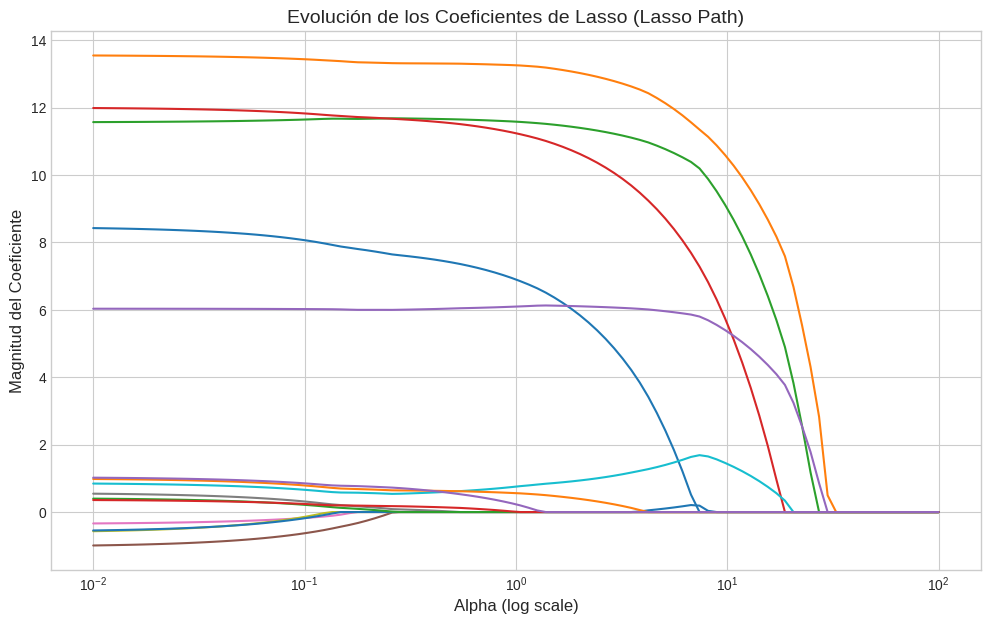


Comparación de Coeficientes:
   Variable  Coeficiente Verdadero  Coeficiente OLS  Coeficiente Lasso (α=0.5)
0       X_1                   8.75             8.47                       7.40
1       X_2                  14.51            13.56                      13.30
2       X_3                  12.32            11.56                      11.65
3       X_4                  10.99            12.00                      11.53
4       X_5                   6.56             6.03                       6.04
5       X_6                   0.00            -1.03                      -0.00
6       X_7                   0.00            -0.36                       0.00
7       X_8                   0.00             0.57                       0.01
8       X_9                   0.00            -0.62                       0.00
9      X_10                   0.00             0.86                       0.61
10     X_11                   0.00            -0.59                       0.00
11     X_12           

In [48]:
# Modelo 1: Mínimos Cuadrados Ordinarios (OLS) - Sin regularización
ols = LinearRegression()
ols.fit(X_train, y_train)
ols_coeffs = ols.coef_

# Modelo 2: Lasso con varios alphas
# Guardaremos los coeficientes para cada alpha para ver su evolución.
alphas = np.logspace(-2, 2, 100)
lasso_coeffs = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    lasso_coeffs.append(lasso.coef_)

# Gráfico: Evolución de los coeficientes de Lasso ("Lasso Path")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(alphas, lasso_coeffs)
ax.set_xscale('log')
ax.set_xlabel('Alpha (log scale)', fontsize=12)
ax.set_ylabel('Magnitud del Coeficiente', fontsize=12)
ax.set_title('Evolución de los Coeficientes de Lasso (Lasso Path)', fontsize=14)
plt.axis('tight')
plt.show()

# Comparación de coeficientes para un alpha intermedio
alpha_ejemplo = 0.5
lasso_ejemplo = Lasso(alpha=alpha_ejemplo)
lasso_ejemplo.fit(X_train, y_train)

df_coeffs = pd.DataFrame({
    'Variable': [f'X_{i+1}' for i in range(n_features)],
    'Coeficiente Verdadero': true_coeffs,
    'Coeficiente OLS': ols_coeffs,
    f'Coeficiente Lasso (α={alpha_ejemplo})': lasso_ejemplo.coef_
})

print("\nComparación de Coeficientes:")
print(df_coeffs.round(2))
print(f"\nNúmero de variables seleccionadas por Lasso (α={alpha_ejemplo}): {np.sum(lasso_ejemplo.coef_ != 0)} de {n_features}")


## PASO 3: EVALUAR DESEMPEÑO FUERA DE MUESTRA Y ESTABILIDAD


Mejor alpha encontrado por Validación Cruzada: 0.4007
Error Cuadrático Medio (MSE) en datos de prueba (fuera de muestra):
 - OLS (sin regularización): 29.7278
 - Lasso (con alpha óptimo): 27.4600

Ejecutando Bootstrap para evaluar estabilidad de selección...


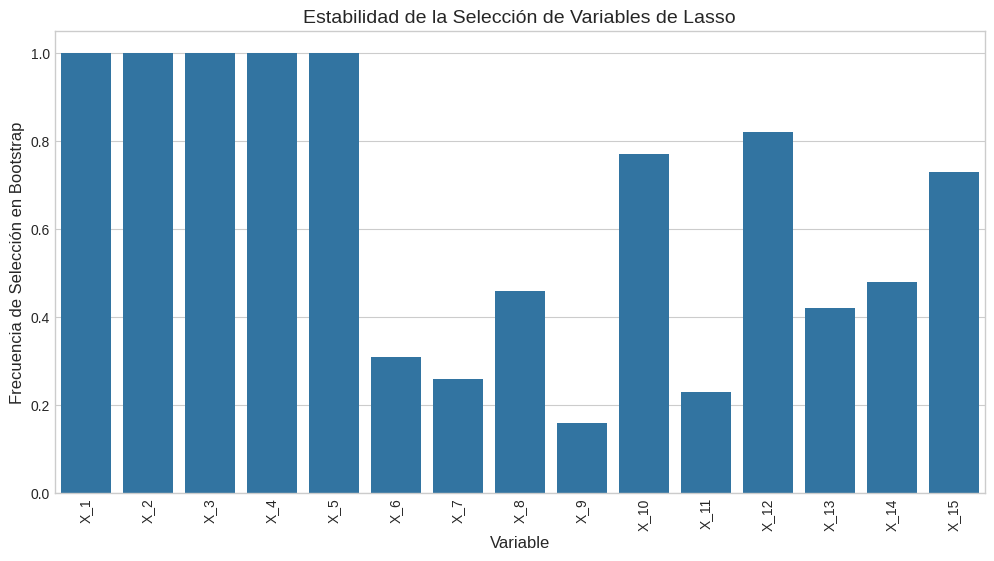

In [49]:

# Usamos LassoCV para encontrar el mejor alpha mediante validación cruzada
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(X_train, y_train)
best_alpha = lasso_cv.alpha_

print(f"\nMejor alpha encontrado por Validación Cruzada: {best_alpha:.4f}")

# Evaluar MSE en el conjunto de prueba (fuera de muestra)
ols_mse = mean_squared_error(y_test, ols.predict(X_test))
lasso_best_mse = mean_squared_error(y_test, lasso_cv.predict(X_test))

print(f"Error Cuadrático Medio (MSE) en datos de prueba (fuera de muestra):")
print(f" - OLS (sin regularización): {ols_mse:.4f}")
print(f" - Lasso (con alpha óptimo): {lasso_best_mse:.4f}")

# Estabilidad de la selección de variables con Bootstrap
n_bootstraps = 100
selected_vars_freq = np.zeros(n_features)

print("\nEjecutando Bootstrap para evaluar estabilidad de selección...")
for i in range(n_bootstraps):
    # Re-muestreo con reemplazo
    indices = np.random.choice(len(X_train), len(X_train), replace=True)
    X_sample, y_sample = X_train[indices], y_train[indices]
    
    # Ajustar Lasso con el mejor alpha
    lasso_boot = Lasso(alpha=best_alpha, max_iter=10000)
    lasso_boot.fit(X_sample, y_sample)
    
    # Contar las variables seleccionadas (coeficiente != 0)
    selected_vars_freq += (lasso_boot.coef_ != 0)

selected_vars_freq /= n_bootstraps

# Gráfico de Frecuencia de Selección
plt.figure(figsize=(12, 6))
sns.barplot(x=[f'X_{i+1}' for i in range(n_features)], y=selected_vars_freq)
plt.xlabel('Variable', fontsize=12)
plt.ylabel('Frecuencia de Selección en Bootstrap', fontsize=12)
plt.title('Estabilidad de la Selección de Variables de Lasso', fontsize=14)
plt.xticks(rotation=90)
plt.show()

## Resultados para varios valores de paŕametros:
### n  = 14, p = 15, correlacion = 0.5:

Error Cuadrático Medio (MSE) en datos de prueba (fuera de muestra):
 - OLS (sin regularización): 265.5438
 - Lasso (con alpha óptimo): 677.5254

### n  = 15, p = 15, correlacion = 0.5:
Error Cuadrático Medio (MSE) en datos de prueba (fuera de muestra):
 - OLS (sin regularización): 130.0389
 - Lasso (con alpha óptimo): 123.2118


### n  = 100, p = 15, correlacion = 0.85:
Error Cuadrático Medio (MSE) en datos de prueba (fuera de muestra):
 - OLS (sin regularización): 27.6593
 - Lasso (con alpha óptimo): 28.5153


## Conclusión:
En escenarios con alta correlación entre características y un número limitado de muestras, Lasso tiende a generalizar peor que OLS, lo que se refleja en un mayor MSE en datos de prueba. Esto sugiere que la regularización puede no ser beneficiosa en todos los contextos, especialmente cuando las características están altamente correlacionadas y el tamaño de la muestra es pequeño.
